In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

import math
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import dvi.bayes_utils as bu
from dvi.dataset import ToyDataset
from dvi.bayes_models import MLP, AdaptedMLP
from dvi.loss import GLLLoss
from dvi.plot import toydata_result_plot

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
TRAIN_SIZE = 500
X_DIM = 1
Y_DIM = 2
LEARNING_RATE = 1e-3
EPOCHS = 20000
ADAPTER = {
        'in': {"scale": [[1.0]], "shift": [[0.0]]},
        'out': {"scale": [[1.0, 0.83]], "shift": [[0.0, -3.5]]}
    }
WARMUP = 14000
ANNEAL = 1000

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    DEVICE = torch.device('cpu')

## Dataset

First we generate a toy dataset according to:
\begin{equation} 
y = -(x+0.5)\sin(3\pi x) + \eta
\end{equation}

Where the noise is generated according to:

\begin{equation}
 \eta = 0.45(x + 0.5)^2
\end{equation}

In [3]:
trainset = ToyDataset(data_size=TRAIN_SIZE, sampling=True)
trainloader = DataLoader(trainset, batch_size=TRAIN_SIZE, shuffle=True)

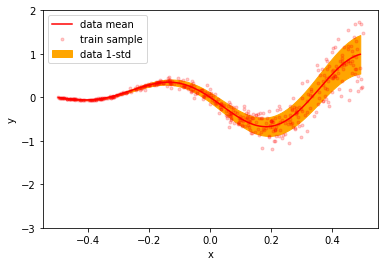

In [4]:
toydata_result_plot(trainloader)

## Model

In [5]:
mlp = MLP(X_DIM, Y_DIM)
model = AdaptedMLP(mlp, ADAPTER, device=DEVICE)
model

AdaptedMLP(
MLP(
  (layers): Sequential(
    (0): VariationalLinearCertainActivations(
      (weight): Parameter(
        Prior: InverseGamma(concentration: 4.479800224304199, scale: 27.39900016784668)
        Variational: Normal(loc: torch.Size([128, 1]), scale: torch.Size([128, 1]))
      )
      (bias): Parameter(
        Prior: InverseGamma(concentration: 4.479800224304199, scale: 27.39900016784668)
        Variational: Normal(loc: torch.Size([128]), scale: torch.Size([128]))
      )
    )
    (1): VariationalLinearReLU(
      (weight): Parameter(
        Prior: InverseGamma(concentration: 4.479800224304199, scale: 0.21405468881130219)
        Variational: Normal(loc: torch.Size([128, 128]), scale: torch.Size([128, 128]))
      )
      (bias): Parameter(
        Prior: InverseGamma(concentration: 4.479800224304199, scale: 0.21405468881130219)
        Variational: Normal(loc: torch.Size([128]), scale: torch.Size([128]))
      )
    )
    (2): VariationalLinearReLU(
      (weight): P

## Training 

In [6]:
criterion = GLLLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=LEARNING_RATE)


In [7]:
def train(epoch, model, criterion, dataloader, optimizer):
    model.mlp.train()

    for xs, ys in dataloader:
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)

        optimizer.zero_grad()

        pred = model(xs)

        kl = model.surprise()

        log_likelihood = criterion(pred, ys)
        batch_log_likelihood = torch.mean(log_likelihood)

        lmbd = bu.anneal(epoch, WARMUP, ANNEAL)

        loss = lmbd * kl / TRAIN_SIZE - batch_log_likelihood

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        optimizer.step()

        accuracy = torch.mean(torch.abs(pred.mean[:, 0].reshape(-1) - ys))
    if epoch % 20 == 0:
        print("Epoch {}: GLL={:.4f}, KL={:.4f}(anneal:{}) | MAE={:.4f}".format(
            epoch, batch_log_likelihood.item(), kl.item()/500, lmbd, accuracy))

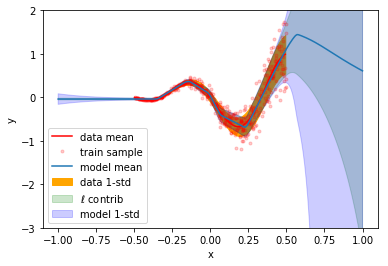

In [8]:
toydata_result_plot(trainloader, model)
plt.show()

for epoch in range(1, EPOCHS+1):
    train(epoch, model, criterion, trainloader, optimizer)
    if epoch % 100 == 0:
        clear_output()
        toydata_result_plot(trainloader, model)
        plt.show()


## Comparison with MC

We compare the output activations of the BNN as predicted using our deterministic approximation with the activations predicted by Monte Carlo approximation (see Figure 3 of the paper)

In [9]:
# from matplotlib import rc
# rc('text', usetex=True)
torch.set_default_tensor_type(torch.FloatTensor)
model.device = torch.device('cpu')
model.make_adapters(model.adapter)
import numpy as np
n_sample = 10000
x = 0.25
with torch.no_grad():
    model.mlp.cpu()
    test_x = torch.ones(n_sample, 1) * x

    samples = model.mcmc(test_x, n_sample)
    tmp = model(test_x)
    approx = [tmp.mean, tmp.var]
    
def gaussian1d(mean, var):
    x_axis = torch.linspace(-5,5,1000)
    return x_axis.cpu().numpy(), (1.0 / torch.sqrt(2.0 * math.pi * var) * torch.exp(-1.0 / (2.0 * var) * (x_axis - mean)**2)).cpu().numpy()

/home/makotok/projects/deterministic-variational-inference-pytorch/dvi/bayes_models.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'scale': torch.tensor(adapter[ad]['scale']).to(self.device),
/home/makotok/projects/deterministic-variational-inference-pytorch/dvi/bayes_models.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'shift': torch.tensor(adapter[ad]['shift']).to(self.device)


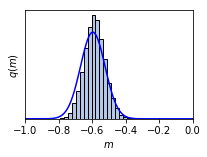

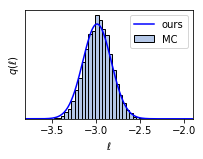

In [23]:
plt.figure(figsize=(3,2))
# plt.hist(samples[:,0,0].cpu().numpy(), int(np.round(200/(1))), density=True, edgecolor='k', facecolor='#b4c7e7')
plt.hist(samples[:,0,0].cpu().numpy(), 30, density=True, edgecolor='k', facecolor='#b4c7e7')

plt.plot(*gaussian1d(approx[0][0,0], approx[1][0,0,0]), 'b')
plt.xlim([-1,-0.0])
plt.yticks([])
plt.xlabel('$m$')
plt.ylabel('$q(m)$')
plt.show()

plt.figure(figsize=(3,2))
# plt.hist(samples[:,0,1].cpu().numpy(), int(np.round(200/(3.8-1.9))), density=True, edgecolor='k', facecolor='#b4c7e7', label="MC")
plt.hist(samples[:,0,1].cpu().numpy(), 30, density=True, edgecolor='k', facecolor='#b4c7e7', label="MC")
plt.plot(*gaussian1d(approx[0][0,1], approx[1][0,1,1]), 'b', label="ours")
plt.xlim([-3.8,-1.9])
plt.yticks([])
plt.xlabel('$\ell$')
plt.ylabel('$q(\ell)$')
plt.legend()
plt.show()